# Archive Version

This notebook follow book "Fight Churn" systematical approach, Showing some profound analysis. 

However, it is bases on different assumption to the capstone project. For example:
- this file take subscribers showing in latest 4 weeks
- this file doesn't consider free user as subscriber, which means under such assumption, churn only for paid user. 


This files serves as a reference, has some good snippet and reusable parts. 
This notebook Not for submission.

For a more 'traditional' approach for capstone project requirement, check out sparkify_min file.


**<a href="#measuring-churn-rate">Measuring Churn Rate</a>**
- <a href="#standard-based-churn-rate">Standard Churn Rate (Subscription)</a>
- <a href="#activity-based-churn-rate">Activity Churn Rate (Non-Subscription)</a>

**<a href="#observing-churn">Observing Churn</a>**
- <a href="#account-tenure">Account Tenure</a>
- <a href="#observation-datetime-picking">Observation Datetime Picking and Outcome</a>

**<a href="#feature-engineering">Feature Engineering (Measuring Customers. Metrics Design)</a>**
- <a href="#common-summay-metrics">Common Summary Metrics (Count, Total, Avg, etc)</a>
- <a href="#analytic-data">Extract Analytic Dataset</a>

**<a href="#cohort-analysis">Metric Cohort Analysis and Plot</a>**
- <a href="#skewness">Skewness Check</a>
- <a href="#normalization">Data Normalization</a>
- <a href="#plot-metric-cohort">Plot and Select</a>

**<a href="#machine-learning">Machine Learning</a> (Churn Forcasting / Predicting)**
- <a href="#ml-regression">Logistic Regression</a>
- <a href="#ml-xgboost">XGBoost</a>


In [346]:
# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt


In [347]:
# Read data
df = pd.read_json('data/mini_sparkify_event_data.json', orient='records', lines=True)
df.head(5)

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [348]:
### Initial Data wrangling

# Drop Anonymous
df = df.drop(np.where(df.userId == '')[0])

# Convert User Id to numeric type
df.userId = df.userId.astype('int')

# Drop 'useless' attributes
df = df.drop(['registration', 'userAgent', 'status', 'method', ], axis=1)
df.head(10)

# Join First Name and Last Name to Fullname column, then drop First Name, Last Name
df['fullname'] = df['firstName'] + ' ' + df['lastName']
df = df.drop(['firstName', 'lastName'], axis=1)

# Create 'datetime' column, based on timpstamp value, convert UTC time for consistency.
# Convert type to pandas datetime type

df['datetime'] = df['ts'].apply(lambda x: datetime.utcfromtimestamp(x/1000).isoformat())
df['datetime'] = df['datetime'].astype('datetime64[ns]')

# Also add a 'date' column to store the date only (not time)
df['date'] = df.ts.apply(lambda x: datetime.utcfromtimestamp(x/1000).isoformat()[:10])

In [349]:
# Spot Check: earlist date and latest date in the dataset
print(np.min(df['datetime']))
print(np.max(df['datetime']))

# Spot Check: Date range in the dataset
print(np.max(df['datetime']) - np.min(df['datetime']))

2018-10-01 00:01:57
2018-12-03 01:11:16
63 days 01:09:19


In [350]:
# Spot Check: Cancellation Event Count
df[(df.page == 'Cancel') | (df.page == 'Cancellation Confirmation')]['page'].value_counts()

Cancel                       52
Cancellation Confirmation    52
Name: page, dtype: int64

In [351]:
# Spot Check: Cancellation Event Count (string method)
df[(df.page.str.startswith('Cancel'))]['page'].value_counts()

Cancel                       52
Cancellation Confirmation    52
Name: page, dtype: int64

In [352]:
# Spot Check: Number of event log records
print(df.shape[0])

# Spot Check: Number of distinct users
print(df.userId.nunique())

278154
225


In [353]:
# Spot Check: Number of 'authentication' values check

df['auth'].value_counts()

Logged In    278102
Cancelled        52
Name: auth, dtype: int64

---

<a id="measuring-churn-rate"></a>

## Measuring Churn Rate

---

observation date recall that follow weekly cycles, so pick a last sunday (or monday 0:00) date as end day

In [354]:
# Set the observation timeframe we want to do churn model.
# 4 Weeks. 

observation_end_date = pd.Timestamp('2018-12-03') # 49th Monday of 2018.
observation_start_date = observation_end_date - pd.Timedelta("28 days") # 45th Monday of 2018

In [355]:
def check_last_event(ids, data=df):
    # Check the last event for a list of users.
    
    # return (page, auth, level, time)
    
    l = []
    
    for i in ids:
        page = data[data.userId == i].tail(1).page.values[0]
        auth = data[data.userId == i].tail(1).auth.values[0]
        level = data[data.userId == i].tail(1).level.values[0]
        dt = pd.Timestamp(data[data.userId == i].tail(1).datetime.values[0])
        
        l.append((i, page, auth, level, dt))
        
    return l


---
<a id="standard-based-churn-rate"></a>

### Standard account-basd churn rate

Glance of churn rate for 2018 Nov full calendar.

Since the limitation of event data, we dont have access to Subscription database (information such as sub id, renew date, therefore, to utilize the event data, we calculate the standard account-based churn rate (for Nov 2018) as:

Number of users whose first event is a paid status last event is also a paid status and not cancel auth
/
Total distinct number of users in the month




In [356]:
# Define 2018 Nov start and end dates
nov_start_date = '2018-11-01T00:00:00'
nov_end_date = '2018-12-01T00:00:00'

# 2018 Nov Data Frame
df_nov = df[(df.datetime > nov_start_date) & (df.datetime < nov_end_date)]

# Distinct user ids in Nov 2018
nov_uids = df_nov.userId.value_counts().index 

# Numbers of user ids in Nov 2018
n_nov_uids = len(nov_uids) 

In [357]:
# The VERY FIRST event for each user in Nov 2018
df_nov_first = df_nov.drop_duplicates('userId', keep='first').\
sort_values('userId')[['userId', 'auth', 'level', 'datetime']]

df_nov_first = df_nov_first.set_index('userId')

In [358]:
# Users that first event in Nov 2018 is under 'paid' status. (Subscriber already)
df_nov_starts_with_paid = df_nov_first[df_nov_first['level'] == 'paid']
df_nov_starts_with_paid

,auth,level,datetime
userId,,,
2,Logged In,paid,2018-11-02 14:49:33
4,Logged In,paid,2018-11-04 13:23:21
6,Logged In,paid,2018-11-01 06:40:13
9,Logged In,paid,2018-11-01 01:49:01
10,Logged In,paid,2018-11-03 14:27:42
...,...,...,...
300020,Logged In,paid,2018-11-13 12:06:12
300021,Logged In,paid,2018-11-01 13:10:20
300022,Logged In,paid,2018-11-05 01:08:50


In [359]:
# The VERY LAST event for each user in Nov 2018

df_nov_last = df_nov.drop_duplicates('userId', keep='last').\
sort_values('userId')[['userId', 'auth', 'level', 'datetime']]

df_nov_last = df_nov_last.set_index('userId')
df_nov_last.head(10)

,auth,level,datetime
userId,,,
2,Logged In,paid,2018-11-21 22:30:04
4,Logged In,paid,2018-11-30 16:32:28
5,Logged In,free,2018-11-08 00:33:21
6,Logged In,paid,2018-11-29 22:48:26
7,Logged In,free,2018-11-23 06:46:51
8,Logged In,free,2018-11-30 13:54:57
9,Logged In,paid,2018-11-30 14:19:12
10,Logged In,paid,2018-11-19 12:49:48
11,Logged In,paid,2018-11-27 09:08:22


In [360]:
# Merger userFirst and userLast. Then check who churn under condition: 
# 1 - if begin with paid, end with free. (cancelled before the very last), OR
# 2 - if begin with paid, end with paid but it is ALSO the last paid event (cancel is the last event)

df_nov_first_last = pd.merge(df_nov_first, df_nov_last, how='inner', on='userId')

df_nov_churn = df_nov_first_last[
    ((df_nov_first_last.level_x == 'paid') & (df_nov_first_last.level_y == 'free')) | 
    ((df_nov_first_last.level_x == 'paid') & (df_nov_first_last.auth_y == 'Cancelled'))
]

df_nov_churn

,auth_x,level_x,datetime_x,auth_y,level_y,datetime_y
userId,,,,,,
28,Logged In,paid,2018-11-01 00:00:06,Cancelled,paid,2018-11-06 00:20:32
29,Logged In,paid,2018-11-01 00:03:11,Cancelled,paid,2018-11-14 07:37:11
35,Logged In,paid,2018-11-01 05:23:02,Logged In,free,2018-11-30 10:24:09
53,Logged In,paid,2018-11-04 00:20:10,Cancelled,paid,2018-11-19 12:34:56
54,Logged In,paid,2018-11-01 00:02:21,Cancelled,paid,2018-11-12 19:40:08
70,Logged In,paid,2018-11-02 01:20:40,Cancelled,paid,2018-11-14 22:34:27
92,Logged In,paid,2018-11-01 05:09:45,Logged In,free,2018-11-30 23:34:25
103,Logged In,paid,2018-11-03 08:27:37,Cancelled,paid,2018-11-04 14:01:31
106,Logged In,paid,2018-11-02 13:07:17,Cancelled,paid,2018-11-02 13:47:04


In [361]:
# Calculate Nov 2018 Churn Rate based on Standard account-based (paid-status or cancellation event)

print(f"Number of customers at the start of nov: {df_nov_starts_with_paid.shape[0]}")
print(f"Number of customers at the end of nov: {df_nov_churn.shape[0]}")

nov_churn_rate = df_nov_churn.shape[0] / df_nov_starts_with_paid.shape[0]

print(f"2018 Nov churn rate: {nov_churn_rate}")
print(f"2018 Nov retention rate: {1 - nov_churn_rate}")

Number of customers at the start of nov: 102
Number of customers at the end of nov: 21
2018 Nov churn rate: 0.20588235294117646
2018 Nov retention rate: 0.7941176470588236


---
<a id="activity-based-churn-rate"></a>
### Activity Based Churn for non-subscriber

In addtion to standard churn rate calculation, I would also calculate churn rate for non-paid ('free') user, based on activity
 measure for Nov 2018.
 
We can obtain an overview of the engagement, utilization of free user. 

How many of free user discontine to use the free service. 

Based on activity recency. Define an inactive time interval, eg 1 month.
Short gaps can be ignore



1. Observe on the start day. (Nov 1), get all free uses have activities within oct 1 - nov 1. Get the head count. 
2. Observe on the end day. (Before Dec 1), get all users have activities within nov 1 - dec 1. Get the head count. 
3. Calculation: End head count / Start head count  (Retaintion Rate)
4. Churn Rate + Retaintion Rate = 1

In [362]:
# Two observations: 
# 1. Observation on start date of the month 
# 2. Observation on end date of the month
# Recency interval: 30 days

nov_start_date = '2018-11-01T00:00:00'
nov_end_date = '2018-12-01T00:00:00'
recency_interval = '30 days'

# Convert to pd timestamp type
free_nov_ob_start_date = pd.Timestamp(nov_start_date)
free_nov_ob_end_date = pd.Timestamp(nov_end_date)

# Calcuate the inactivity limit for start and end
recency_start_date = free_nov_ob_start_date - pd.Timedelta(recency_interval)
recency_end_date = free_nov_ob_end_date - pd.Timedelta(recency_interval)

print(recency_start_date)
print(recency_end_date)

2018-10-02 00:00:00
2018-11-01 00:00:00


In [363]:
# Free users count at the start

free_start_count = df[
    (df.datetime >= recency_start_date) & 
    (df.datetime < recency_end_date) & 
    (df.level == 'free')
].groupby('userId').size().shape[0]

free_start_count

173

In [364]:
# Free users count at the end

free_end_count = df[
    (df.datetime >= recency_end_date) & 
    (df.datetime < nov_end_date) & 
    (df.level == 'free')
].groupby('userId').size().shape[0]

free_end_count # retain

103

In [365]:
print(f"Number of free users churn for 2018 Nov (Based on activity recency): {free_start_count - free_end_count}")

print(f"Free Users Churn Rate for 2018 Nov (Based on activity recency): \
{(free_start_count - free_end_count) / free_start_count}")

print(f"Free Users Retain Rate for 2018 Nov (Based on activity recency): \
{free_end_count / free_start_count}")

Number of free users churn for 2018 Nov (Based on activity recency): 70
Free Users Churn Rate for 2018 Nov (Based on activity recency): 0.4046242774566474
Free Users Retain Rate for 2018 Nov (Based on activity recency): 0.5953757225433526


---

<a id="observing-churn"></a>

## Observing Churn


### Approach Overview
- Get Account tenure.
- Picking observation dates from subscribers
- Export the observations point list

Forming Churn analysis dataset — A dataset in which every row represents a customer facing the decision to churn or stay. 

The outcome is what they do. The facts about these situations are the customer’s behavioral metric measurements.

Observe them all at the interval **relative to their life cycle** with the product, which makes them comparable.


#### About LeadTime

Since we have not details access for every user's exact sub/renew date (although, some can be inferenced from event, 
evidence of first transit from free to paid during timeframe. **However**, some users whose first event in log are already with 'paid', means that they are already ongoing subscribers we don't know when exactly they sub).

Therefore we won't have all sub/renew date for subscribers. Not a good idea to user LeadTime which suggests
observe at one-week before monthly renewal.
For this case, event log only data, to make it consistent for known retain | churn users, I use **Sequence of Regularly Spaced** Observation dates that **relative** to each distinct user. 

#### Observation DateRange and Outcome Set

Make an observation date range dataset. Each row is a sub user's observation date range and is_churn outcome.
(a user can have multiple observation date range)

USER | OBSERVATION_TIME | OUTCOME

(OBSERVATION_DATE represents the end date of the observation with interval length days. Garantee to have interval days), therefor no need to input observationFrom date. If not enough interval days, It will not make it an observation 

#### Relative Observations Parameters (adjustable)

- Observation Interval(Length): 28 days
- Frequency: 14 days (observe every 14 days)
- (Iterate backwards to search possible observations)


#### Variables
- first_log_time: a user's very first shown log date. No matter under 'free' or 'paid.
- tenure_from: The start paid datetime of a user's latest subscription's from date.
- tenure_to: The latest paid datetime of a user's latest subscription's to date. (It can be the churn day or sub ongoing day)
- Initial is_churn outcome. (the latest of 'paid' event, ongoing or churn)



#### Users to select
- Select the users from the **latest 4 weeks**. Range: (**>= 45th Monday of 2018 AND < 49th Monday of 2018**)
that is \[>= 2018-11-05 to < 2018-12-03\]
- Users who are ongoing subscribers OR are churn in this timeframe
- (Why not use a full month calendar, e.g Nov 2018? We can. But again, the dataset is a event log, latest records are not completed in a full month Dec instances, so use relative of latest. Use **units of full weeks**. Comsumer Human Behaviors follows WEEK cycle: for example, monday to friday busy, sat, sun more usage for consumer service)

In [366]:
### Extract Subscriber user ids (Find out subscribers that are appear within the latest 4 week.)

# Establish timeframe:  Set the timeframe we want: latest 4 Weeks. 
range_to = pd.Timestamp('2018-12-03') # 49th Monday of 2018.
range_from = range_to - pd.Timedelta("28 days") # 45th Monday of 2018

# Make a subset to extract user ids that we concern.
dfu = df[(df.datetime >= range_from) & (df.datetime < range_to)]

# Get all subscriber users ids within this range (subscribers)
uids = dfu[dfu['level'] == 'paid'].drop_duplicates('userId', keep='last').sort_values(by='userId')['userId'].values

# These subsribers and their last events within the range.
uids_last_e = check_last_event(uids, data=dfu)

# Separate Retain uids and Churn uids. Condition to check:
# 1) if the last e is 'free', means user trainsited from paid to free within the timeframe, OR
# 2) even tho last is 'paid', but its a 'Cancelled' auth, means the 'paid' user submit cancel. 

# Churn users ids
u_churn = [x[0] for x in uids_last_e if (x[3] == 'free') or (x[2] == 'Cancelled')]
print(len(u_churn))

# Retain users
u_retain = [x[0] for x in uids_last_e if (x[3] == 'paid') and (x[2] != 'Cancelled')]
print(len(u_retain))


21
111


<a id="account-tenure"></a>
### Account Tenure

tenure should measure only the current subscription. (in this case, subscribers within latest 4-weeks)



In [367]:
# Experiment cumcount() shift(). Rolling count. 
# Code snippet reference: https://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count

dft = pd.DataFrame({
    'x': [1,2,3,4,5,6,7,8,9,10,11],
    'y': ['a','a', 'a', 'b', 'b','b','b','b','a','a','a']})

dft.groupby(
    (dft['y'] != dft['y'].shift(1)).cumsum()
).cumcount()

0     0
1     1
2     2
3     0
4     1
5     2
6     3
7     4
8     0
9     1
10    2
dtype: int64

In [368]:
# Utility Function. Get tunure days
def get_tenures(ids=uids):
     
    """
    Get user's tenure days.
    Key value pair.
    
    Input: list of user ids. Assuming that argument ids are paid user. 
    Output: dict of key value pairs. key: user, value: tunure
    """
        
    tenures = {}
    
    for i in ids:
        # Subset a dataframe for the user
        dfu = df[(df.datetime < observation_end_date) & (df.userId == i)]
        
        # Make a cumulative count column
        dfu['cumcount'] = dfu.groupby(
            (dfu['level'] != dfu['level'].shift(1)).cumsum()
        ).cumcount()
        
        # Start Date of latest subscription
        start = dfu[(dfu.cumcount == 0) & (dfu.level == 'paid')].tail(1).iloc[0].datetime
        start_date = str(start)[:10]
        
        # End Date of latest subscription
        end = dfu[
            (dfu.level == 'paid') & (~dfu.page.str.startswith('Cancel'))
        ].tail(1).iloc[0].datetime
        end_date = str(end)[:10]
        
        diff = pd.Timestamp(end_date) - pd.Timestamp(start_date)
        # print(diff.days)
        
        # append result, first day starts with 0
        tenures[i] = diff.days
        
    return tenures

tenures = get_tenures()
tenures

/var/folders/z2/4x1xtsmd40sfmyp2ftrfbkfh0000gn/T/ipykernel_37353/2193141223.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfu['cumcount'] = dfu.groupby(


{2: 44,
 4: 40,
 6: 54,
 9: 30,
 10: 42,
 11: 11,
 13: 0,
 14: 49,
 15: 55,
 16: 57,
 20: 10,
 21: 34,
 23: 2,
 25: 10,
 26: 0,
 28: 8,
 29: 37,
 30: 2,
 33: 57,
 35: 13,
 36: 17,
 37: 43,
 38: 37,
 39: 0,
 40: 30,
 41: 51,
 42: 54,
 45: 39,
 46: 29,
 49: 0,
 50: 9,
 52: 26,
 53: 26,
 54: 14,
 55: 0,
 56: 22,
 59: 24,
 60: 46,
 61: 26,
 62: 50,
 65: 53,
 66: 35,
 67: 31,
 69: 47,
 70: 42,
 71: 26,
 74: 27,
 75: 52,
 77: 35,
 79: 15,
 81: 42,
 82: 23,
 83: 24,
 85: 33,
 86: 16,
 88: 34,
 89: 22,
 91: 35,
 92: 46,
 93: 3,
 96: 4,
 97: 32,
 98: 36,
 99: 23,
 100: 16,
 104: 36,
 108: 23,
 109: 36,
 111: 27,
 113: 58,
 114: 30,
 115: 54,
 118: 49,
 120: 60,
 124: 60,
 126: 42,
 127: 56,
 128: 45,
 131: 49,
 132: 50,
 136: 45,
 137: 1,
 138: 39,
 139: 20,
 140: 10,
 141: 41,
 142: 60,
 145: 57,
 147: 16,
 151: 0,
 152: 15,
 153: 22,
 155: 19,
 100002: 38,
 100004: 2,
 100007: 58,
 100008: 42,
 100014: 41,
 100015: 22,
 100016: 53,
 100018: 37,
 200002: 28,
 200003: 4,
 200004: 55,
 200005: 2

In [369]:
print(len(tenures))
print(tenures[25])

132
10


In [370]:
# Make a tenure dataframe base on above
df_tenure = pd.DataFrame(
    {
        "userId": [x[0] for x in uids_last_e],
        "page": [x[1] for x in uids_last_e],
        "auth": [x[2] for x in uids_last_e],
        "level": [x[3] for x in uids_last_e],
        "latest_log_time": [x[4] for x in uids_last_e],
    }
)

# Add info to df_tenure
# is_churn: 
# tenure_days: 
# tenure_from:
# tenure_to:
# first_log_time: 

def _get_is_churn(l, a):
    
    if (l == 'free') or (a == 'Cancelled'):
        return 1
    else:
        return 0
    
def _get_tenure_to_time(x):
    return dfu[(dfu.userId == x) & (dfu.level=='paid')].iloc[-1].datetime

def _get_tenure_from_time(u, t):
    
    tenure_days = tenures[u]
    dfx = df[df.userId == u]
    from_date = (t - pd.Timedelta(f'{tenure_days} days')).isoformat()[:10]
    tenure_from = dfx[(dfx.level=='paid') & (dfx.date==from_date)].iloc[0].datetime
    
    return tenure_from

def _get_first_log_date(x):
    return df[df.userId==x].iloc[0].datetime
    

    
# Add Columns

df_tenure['is_churn'] = df_tenure.apply(lambda x: _get_is_churn(x.level, x.auth), axis=1)
df_tenure['tenure_days'] = df_tenure['userId'].apply(lambda x: tenures[x])
df_tenure['tenure_to'] = df_tenure['userId'].apply(_get_tenure_to_time)
df_tenure['tenure_from'] = df_tenure.apply(lambda x: _get_tenure_from_time(x.userId, x.tenure_to), axis=1)
df_tenure['first_log_time'] = df_tenure['userId'].apply(_get_first_log_date)


In [371]:
df_tenure.head(5)

,userId,page,auth,level,latest_log_time,is_churn,tenure_days,tenure_to,tenure_from,first_log_time
0,2,Add Friend,Logged In,paid,2018-11-21 22:30:04,0,44,2018-11-21 22:30:04,2018-10-08 04:49:55,2018-10-08 04:49:55
1,4,Add to Playlist,Logged In,paid,2018-11-30 16:32:28,0,40,2018-11-30 16:32:28,2018-10-21 11:29:03,2018-10-01 01:17:30
2,6,Home,Logged In,paid,2018-11-29 22:48:26,0,54,2018-11-29 22:48:26,2018-10-06 15:37:21,2018-10-01 15:11:43
3,9,Home,Logged In,paid,2018-11-30 14:19:12,0,30,2018-11-30 14:19:12,2018-10-31 03:25:12,2018-10-01 00:03:00
4,10,Downgrade,Logged In,paid,2018-11-19 12:49:48,0,42,2018-11-19 12:49:48,2018-10-08 02:20:20,2018-10-08 02:20:20


<a id="observation-datetime-picking"></a>
### Observation Datetime Picking Algorithm

Define date picking constant parameter (adjustable)
- **frequency = pd.Timedelta('14 days')**: how often to measure an user.
- **interval = pd.Timedelta('28 days')**: for each measurement (observation), how many days to observe.  

Boundary datetime range for user within its tenure range to iterate. (tenure range).

For every iteration of observation_time (It is the TO date, NOT from). And it must be within the tenure range.



- For ongoing/retain users, is_churn ALWAYS False, any iteration of observation's outcome is_churn ALL False.
- For churn users, the initial observation is_churn is True, any following iteration outcomes (if exist, means they were under the 'paid' level) is_churn are False.


1) Condition: If an observation is within tenure range, record it. Loop to next frequency, check agian if is within range, record then loop next.

- Retain Users: It is guarentee to be NotChurn since it is within his/her the tenure range, so that no worry if it has record on the date or nearest date. 
- Churn Users: intial outcome always IsChurn, but any following iterations of observation are not.


2) Condition: If a observation date - user's first event date >= interval (means enough observation interval)



In [372]:
# Pseudo 

# observations = []
# intial ob_date = tenure_end_date
#
# while (ob_date isin tenure daterange), AND (ob_data - first_event_date >= interval)
#    ob_date_from = ob_date - interval
#    ob_churn_outcome = False
#    obervations.append([ob_data_from, ob_date, ob_churn_outcome])
#    ob_date -= frequency
#    

# Define Parameters. (Adjustable)
frequency = pd.Timedelta('14 days') # observation frequency. every x days. 
interval = pd.Timedelta('28 days') # length of each observation


def get_observations(userId):
    """
    Make observations of datetime range and churn outcome for a subscriber.
    
    Output: list of tuples. 
    """
    
    ds = df_tenure[df_tenure.userId==userId].iloc[0]
    
    first_log_time = ds.first_log_time
    tenure_from = ds.tenure_from
    
    tenure_to = ds.tenure_to

    # Initial observation time is tenure_to time
    obsevation_time = tenure_to

    # Initializer
    observations = []
    
    while (tenure_from <= obsevation_time <= tenure_to) & (obsevation_time - interval >= first_log_time):
        observations.append(obsevation_time)
        obsevation_time -= frequency
        
    # If user is in churn user list, initial observation always True, otherwise False
    if (userId in u_churn):
        res = [(userId, x, 1) if x == tenure_to else (userId, x, 0) for x in observations]
    else:
        res = [(userId, x, 0) for x in observations]
        
    return res
    
    
# Spot Check
get_observations(300004)

[(300004, Timestamp('2018-11-14 19:49:26'), 1)]

In [373]:
# Generate observation daterange outcome dataset and convert to numpy array.

def make_datetime_picking_outcome_dateset(sub_ids=u_churn + u_retain):
#     sub_ids = u_churn + u_retain
    
    userIds = []
    observation_times = []
    outcomes = []
    
    for i in sub_ids:
        for k in get_observations(i):
            userIds.append(k[0])
            observation_times.append(k[1])
            outcomes.append(k[2])
            
    res = pd.DataFrame({
        'userId': userIds,
        'observation_time': observation_times,
        'is_churn': outcomes
    })
    
    return res


df_obs = make_datetime_picking_outcome_dateset()
df_obs = df_obs.sort_values(['userId', 'observation_time'], ascending=[True, True]).reset_index().drop('index', axis=1)

# Convert to np array
# For every observation instance, calculate metrics, e.g number of song play, n like etc
np_obs = np.array(df_obs)
np_obs

array([[2, Timestamp('2018-11-07 22:30:04'), 0],
       [2, Timestamp('2018-11-21 22:30:04'), 0],
       [4, Timestamp('2018-11-02 16:32:28'), 0],
       [4, Timestamp('2018-11-16 16:32:28'), 0],
       [4, Timestamp('2018-11-30 16:32:28'), 0],
       [6, Timestamp('2018-11-01 22:48:26'), 0],
       [6, Timestamp('2018-11-15 22:48:26'), 0],
       [6, Timestamp('2018-11-29 22:48:26'), 0],
       [9, Timestamp('2018-11-02 14:19:12'), 0],
       [9, Timestamp('2018-11-16 14:19:12'), 0],
       [9, Timestamp('2018-11-30 14:19:12'), 0],
       [10, Timestamp('2018-11-05 12:49:48'), 0],
       [10, Timestamp('2018-11-19 12:49:48'), 0],
       [11, Timestamp('2018-11-27 09:08:22'), 0],
       [13, Timestamp('2018-11-08 07:44:01'), 1],
       [14, Timestamp('2018-11-13 23:48:14'), 0],
       [14, Timestamp('2018-11-27 23:48:14'), 0],
       [15, Timestamp('2018-11-11 04:56:58'), 0],
       [15, Timestamp('2018-11-25 04:56:58'), 0],
       [16, Timestamp('2018-11-02 02:20:11'), 0],
       [16,

---

<a id="feature-engineering"></a>

## Feature Engineering (Metrics Design)


###  Overview


- Measuring counts, averages, and totals of customer events 
- Measuring how long a customer has been using a service (Tenure)
- Measuring change metric, ratio metric.

### Fetures (Metrics) Design

Common summary metrics: for discret data : count, total, avg; for continous data type (e.g playback duration): sum.

Other metrics: rolling change of percentage; ratio of multiple metrics

In [374]:
# Subset dataset only contain the selected within-range (latest 4 weeks) subscriber (uids)
# Full date range as original set. (Oct, Nov, Dec2days)
dfs = df[df.userId.isin(uids)]

In [375]:
# Computing Metrics functions

def get_n_songplay(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['NextSong']
    except:
        res = 0
        
    return res


def get_n_like(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Thumbs Up']
    except:
        res = 0
        
    return res


def get_n_dislike(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Thumbs Down']
    except:
        res = 0
        
    return res


def get_n_addtoplaylist(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Add to Playlist']
    except:
        res = 0
        
    return res

def get_n_addfriend(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Add Friend']
    except:
        res = 0
        
    return res


def get_n_adview(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Roll Advert']
    except:
        res = 0
        
    return res


def get_n_viewdowngrade(uid, d_from, d_to):
    ds = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]\
.page.value_counts()
    
    try:
        res = ds['Downgrade']
    except:
        res = 0
        
    return res


def get_n_session(uid, d_from, d_to):
    
    try:
        res = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)].sessionId.nunique()
    except:
        res = 0
        
    return res



def get_total_playlength(uid, d_from, d_to):
    
    try:
        res = math.ceil(dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)]['length'].sum())
    except:
        res = 0
        
    return res

def get_tenure_days(uid, u_to):
    res = (pd.Timestamp(str(d_to)[:10]) - \
           pd.Timestamp(str(df_tenure[df_tenure.userId==uid].tenure_from.iloc[0])[:10])).days
    
    return res


def get_ratio_length_per_session(total_playlength, n_session):
        
        res = round(total_playlength / n_session, 4) if n_session > 0 else 0
        return res
    

def get_ratio_like_per_songplay(n_like, n_songplay):
        
        res = round(n_like / n_songplay, 4) if n_songplay > 0 else 0
        return res
    

def get_ratio_dislike_per_songplay(n_dislike, n_songplay):
        
        res = round(n_dislike / n_songplay, 4) if n_songplay > 0 else 0
        return res
    
def get_ratio_addplaylist_per_songplay(n_addtoplaylist, n_songplay):
        
        res = round(n_addtoplaylist / n_songplay, 4) if n_songplay > 0 else 0
        return res
    

def get_n_distinct_artist(uis, d_from, d_to):

    try:
        res = dfs[(dfs.userId==uid) & (dfs.datetime > d_from) & (dfs.datetime <= d_to)].artist.dropna().nunique()
    except:
        res = 0
        
    return res
    

def get_songplay_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_songplay(uid, d_from, d_to)
    start = get_n_songplay(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG SONG CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


def get_like_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_like(uid, d_from, d_to)
    start = get_n_like(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG LIKE CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


def get_dislike_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_dislike(uid, d_from, d_to)
    start = get_n_dislike(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG DISLIKE CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


def get_addtoplaylist_change_perc(uid, d_from, d_to):
    
    first_log_time = df_tenure[df_tenure.userId==uid]['first_log_time'].iloc[0]
    delta = frequency
    
    end = get_n_addtoplaylist(uid, d_from, d_to)
    start = get_n_addtoplaylist(uid, d_from - delta, d_to - delta)
    
    if (start == 0):
        # print("DEBUG ADDTOPLAYLIST CHANGE: DENOMINATOR START IS 0")
        # plus 1 in case denominator 0 to avoid error
        start = 1
        
    perc = (end / start) - 1
    perc = round(perc, 4)
    
    if (d_from - delta < first_log_time):
        # not enough timerange data to compare with, 
        # which means 'unfair' comparation with previous timeframe
        # default to 0% change.
        perc = 0
    
    return perc


<a id="analytic-data"></a>

### Extract Analytic Dataset

Compute the metrics for each observation point, then 

Creating an analytic dataset by flattening metric data.


In [376]:
### Initialize empty list for pandas datamframe data. Flatten analytic data. 
data_uid = []
data_to = []

data_n_songplay = []
data_n_session = []
data_n_addtoplaylist = []
data_n_addfriend = []
data_n_like = []
data_n_dislike = []
data_n_viewdowngrade = []
data_tenure = []

data_total_playlength = []

data_ratio_length_per_session = []
data_ratio_addplaylist_per_songplay = []
data_ratio_like_per_songplay = []
data_ratio_dislike_per_songplay = []

data_change_perc_songplay = []
data_change_perc_addtoplaylist = []
data_change_perc_like = []
data_change_perc_dislike = []

data_is_churn = []



### Get metrics for every observation instance
for i in np_obs:
    uid = i[0]
    d_to = i[1]
    d_from = d_to - interval
    is_churn = i[2]
    
    n_songplay = get_n_songplay(uid, d_from, d_to)
    n_session = get_n_session(uid, d_from, d_to)
    total_playlength = get_total_playlength(uid, d_from, d_to)
    
    n_addtoplaylist = get_n_addtoplaylist(uid, d_from, d_to)
    # n_artist = get_n_distinct_artist(uid, d_from, d_to)
    n_addfriend = get_n_addfriend(uid, d_from, d_to)
    
    n_like = get_n_like(uid, d_from, d_to)
    n_dislike = get_n_dislike(uid, d_from, d_to)
    # n_adview = get_n_adview(uid, d_from, d_to)
    n_viewdowngrade = get_n_viewdowngrade(uid, d_from, d_to)
    
    tenure = get_tenure_days(uid, d_to)
    
    ratio_length_per_session = get_ratio_length_per_session(total_playlength, n_session)
    ratio_addplaylist_per_songplay = get_ratio_addplaylist_per_songplay(n_addtoplaylist, n_songplay)
    ratio_like_per_songplay = get_ratio_like_per_songplay(n_like, n_songplay)
    ratio_dislike_per_songplay = get_ratio_dislike_per_songplay(n_dislike, n_songplay)
    
    change_perc_songplay = get_songplay_change_perc(uid, d_from, d_to)
    change_perc_addtoplaylist = get_addtoplaylist_change_perc(uid, d_from, d_to)
    change_perc_like = get_like_change_perc(uid, d_from, d_to)
    change_perc_dislike = get_dislike_change_perc(uid, d_from, d_to)
    
    
    
    # Append variable data to datalist
    data_uid.append(uid)
    data_to.append(d_to)
    
    data_n_songplay.append(n_songplay)
    data_n_session.append(n_session)
    data_n_addtoplaylist.append(n_addtoplaylist)
    data_n_addfriend.append(n_addfriend)
    data_n_like.append(n_like)
    data_n_dislike.append(n_dislike)
    data_n_viewdowngrade.append(n_viewdowngrade)
    data_tenure.append(tenure)
    
    data_total_playlength.append(total_playlength)
    
    data_ratio_length_per_session.append(ratio_length_per_session)
    data_ratio_addplaylist_per_songplay.append(ratio_addplaylist_per_songplay)
    data_ratio_like_per_songplay.append(ratio_like_per_songplay)
    data_ratio_dislike_per_songplay.append(ratio_dislike_per_songplay)
    
    data_change_perc_songplay.append(change_perc_songplay)
    data_change_perc_addtoplaylist.append(change_perc_addtoplaylist)
    data_change_perc_like.append(change_perc_like)
    data_change_perc_dislike.append(change_perc_dislike)
    
    data_is_churn.append(is_churn)
    
    
    ### Print Spot Check
    
#     print()
#     print(f"uid: {uid}")
#     print(f"observe from: {d_from}")
#     print(f"observe to: {d_to}")
#     print(f"n_songplay: {n_songplay}")
#     print(f"n_session: {n_session}")
#     # print(f"n_artist: {n_artist}")
    
#     print(f"n_addtoplaylist: {n_addtoplaylist}")
#     print(f"n_addfriend: {n_addfriend}")
#     print(f"n_like: {n_like}")
#     print(f"n_dislike: {n_dislike}")
#     # print(f"n_adview: {n_adview}")
#     print(f"n_viewdowngrade: {n_viewdowngrade}")
#     print(f"tenure: {tenure} days")
    
#     print(f"total_playlength: {total_playlength}")
#     print(f"ratio_length_per_session: {ratio_length_per_session}")
#     print(f"ratio_addplaylist_per_songplay: {ratio_addplaylist_per_songplay}")
#     print(f"ratio_like_per_songplay: {ratio_like_per_songplay}")
#     print(f"ratio_dislike_per_songplay: {ratio_dislike_per_songplay}")
    
#     print(f"change_perc_songplay: {change_perc_songplay}")
#     print(f"change_perc_addtoplaylist: {change_perc_addtoplaylist}")
#     print(f"change_perc_like: {change_perc_like}")
#     print(f"change_perc_dislike: {change_perc_dislike}")
    
#     print(f"is_churn: {is_churn}")
    

### Make a flatten analytic summary dataframe
df_analytic = pd.DataFrame({
    'userId': data_uid,
    'observation_time': data_to,
    'n_songplay': data_n_songplay,
    'n_session': data_n_session,
    'n_addtoplaylist': data_n_addtoplaylist,
    'n_addfriend': data_n_addfriend,
    'n_like': data_n_like,
    'n_dislike': data_n_dislike,
    'n_viewdowngrade': data_n_viewdowngrade,
    'tenure': data_tenure,
    'total_playlength': data_total_playlength,
    
    'ratio_length_per_session': data_ratio_length_per_session,
    'ratio_addplaylist_per_songplay': data_ratio_addplaylist_per_songplay,
    'ratio_like_per_songplay': data_ratio_like_per_songplay,
    'ratio_dislike_per_songplay': data_ratio_dislike_per_songplay,
    
    'change_perc_songplay': data_change_perc_songplay,
    'change_perc_addtoplaylist': data_change_perc_addtoplaylist,
    'change_perc_like': data_change_perc_like,
    'change_perc_dislike': data_change_perc_dislike,
    
    'is_churn': data_is_churn
})


In [377]:
df_analytic

,userId,observation_time,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_songplay,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
0,2,2018-11-07 22:30:04,154,4,2,6,4,0,2,30,36986,9246.5000,0.0130,0.0260,0.0000,0.0000,0.0000,0.0000,0.0000,0
1,2,2018-11-21 22:30:04,396,6,8,13,12,3,7,44,97987,16331.1667,0.0202,0.0303,0.0076,1.5714,3.0000,2.0000,2.0000,0
2,4,2018-11-02 16:32:28,846,10,21,15,34,13,8,12,209280,20928.0000,0.0248,0.0402,0.0154,0.0000,0.0000,0.0000,0.0000,0
3,4,2018-11-16 16:32:28,1434,9,36,34,66,16,16,26,354367,39374.1111,0.0251,0.0460,0.0112,0.6950,0.7143,0.9412,0.2308,0
4,4,2018-11-30 16:32:28,1183,11,38,31,61,13,13,40,291196,26472.3636,0.0321,0.0516,0.0110,-0.1750,0.0556,-0.0758,-0.1875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,300022,2018-11-27 17:28:28,165,8,5,3,10,2,0,50,41985,5248.1250,0.0303,0.0606,0.0121,0.5000,1.5000,0.4286,-0.3333,0
246,300023,2018-11-29 17:49:21,756,13,24,10,68,10,7,0,188982,14537.0769,0.0317,0.0899,0.0132,0.0957,0.1429,0.0000,0.2500,0
247,300025,2018-11-02 07:12:50,827,9,29,13,94,6,5,24,205667,22851.8889,0.0351,0.1137,0.0073,0.0000,0.0000,0.0000,0.0000,0
248,300025,2018-11-16 07:12:50,390,7,11,3,47,4,2,38,95547,13649.5714,0.0282,0.1205,0.0103,-0.5284,-0.6207,-0.5000,-0.3333,0


In [378]:
df_analytic.describe()

,userId,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_songplay,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
count,250.000000,250.000000,250.0000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,68458.144000,835.816000,9.5480,24.028000,15.308000,46.916000,8.524000,7.892000,29.352000,208306.440000,23860.546362,0.028043,0.057221,0.010451,0.793870,0.340002,0.357170,0.194354,0.084000
std,116832.592358,586.750399,7.2483,17.624919,11.568078,35.763909,7.364944,6.931125,16.134602,146475.581186,13617.520509,0.008115,0.017842,0.006716,7.232136,1.259237,1.887134,0.728158,0.277944
min,2.000000,12.000000,1.0000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3112.000000,3112.000000,0.000000,0.026000,0.000000,-0.829600,-0.857100,-0.859200,-1.000000,0.000000
25%,55.250000,392.250000,5.0000,11.000000,7.000000,23.000000,3.000000,3.000000,16.000000,98210.750000,15068.375000,0.022900,0.045900,0.006925,0.000000,0.000000,0.000000,0.000000,0.000000
50%,104.000000,695.500000,8.0000,21.000000,13.000000,38.000000,7.000000,6.000000,30.000000,172809.500000,21557.694450,0.028100,0.052600,0.009150,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100014.750000,1168.500000,11.0000,35.000000,20.000000,63.000000,11.000000,12.000000,41.750000,289452.500000,30441.114275,0.033000,0.062050,0.012675,0.297825,0.304850,0.301350,0.250000,0.000000
max,300025.000000,3582.000000,53.0000,113.000000,82.000000,223.000000,48.000000,49.000000,60.000000,892427.000000,118382.000000,0.061900,0.127700,0.047900,112.000000,11.000000,27.000000,4.000000,1.000000


<a id="cohort-analysis"></a>
## Metric Cohort Analysis

Check each metric with churn rate.

For example, with a metric, divide user into n cohort groups based on metric values, then find out each group's churn rate.  

In [379]:
# Plot a metric with its n cohorts, each cohort's mean value against each cohort's churn rate (mean)

def cohort_plot(metric_to_plot='', n_cohort=10, df_data=df_analytic):
    # Reference: 
    # https://github.com/carl24k/fight-churn/blob/master/fightchurn/listings/chap5/listing_5_1_cohort_plot.py
    
    # Divide to n groups
    groups = pd.qcut(df_data[metric_to_plot], n_cohort, duplicates='drop')
    # print(groups)
    
    # each group's mean values as x-axis values
    cohort_means = df_data.groupby(groups)[metric_to_plot].mean()
    # print(cohort_means)
    
    # each group's churn rate as y-axis values
    cohort_churns = df_data.groupby(groups)['is_churn'].mean()
    # print(cohort_churns)
    
    plot_data = pd.DataFrame({
        metric_to_plot: cohort_means.values,
        'churn_rate': cohort_churns.values
    })
        
    # plot
    plt.figure(figsize=(6, 4))
        
    plt.plot(metric_to_plot, 'churn_rate',
             data=plot_data,
             marker='o', 
             color='black', 
             linewidth=2, 
             label=metric_to_plot
            )
        
    plt.xlabel('Cohort Average of  "%s"' % metric_to_plot)
    plt.ylabel('Cohort Churn Rate')
    plt.grid()
    plt.gca().set_ylim(bottom=0)



In [380]:
def plot_metrics(metrics, n_cohort, df_data):
    """
    Helper Function, plot every metrics for a given dataframe. 
    """
    for metric in metrics:
        cohort_plot(metric, n_cohort=10, df_data=df_data)



#### Plot every metric cohort. (Un-normailized dataset)

Uncomment below cell to see.

Note that: noizy from skewness. It is better plot with normailized data (in below). 

In [381]:

# plot_metrics(metrics=df_analytic.columns[2:-1], n_cohort=10, df_data=df_analytic) 

<a id="skewness"></a>
### Skewness Check

Bottomline: high skewed metric can be unreliable / problematic.

"A skewed metric is one in which the top cohort contains values several times higher than those 
of the next-closest cohort. Typically, most of the lower cohorts have averages within a relatively small range."

"One issue is that metrics can be skewed, which can make cohort analyses hard to read and hard to compare." - Gold, Carl. "Fighting Churn with Data"

A skewed metric that around to zero, indicating it is approach evenly disbutued around mean. more evenly qcut group.
If a skewness is too high, e.g >= 4. It may result a fat-tail, such case, right long-tail shape, that most of the metric values are before the mean value. 

In [382]:
# Skew Summary Code snippet reference:
# https://github.com/carl24k/fight-churn/blob/master/fightchurn/listings/chap5/listing_5_2_dataset_stats.py


# Drop Non-metric columns
skewness_data = df_analytic.drop(['userId', 'observation_time'], axis=1)

# Transpose the describe result.
skewness_summary = skewness_data.describe()
skewness_summary = skewness_summary.transpose()

# Add skewness information
skewness_summary['skew'] = skewness_data.skew()
skewness_summary['1%'] = skewness_data.quantile(q=0.01)
skewness_summary['99%'] = skewness_data.quantile(q=0.99)
skewness_summary['nonzero'] = skewness_data.astype(bool).sum(axis=0) / skewness_data.shape[0]

skewness_summary = skewness_summary[['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max']]
skewness_summary.columns = skewness_summary.columns.str.replace("%", "pct")

# skewness_summary['skew'] 
skewness_summary

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
n_songplay,250.0,1.000,835.816000,586.750399,1.272369,12.0000,63.470000,392.250000,695.50000,1168.500000,2582.540000,3582.0000
n_session,250.0,1.000,9.548000,7.248300,2.230344,1.0000,1.000000,5.000000,8.00000,11.000000,35.510000,53.0000
n_addtoplaylist,250.0,0.988,24.028000,17.624919,1.293695,0.0000,0.490000,11.000000,21.00000,35.000000,75.100000,113.0000
n_addfriend,250.0,0.984,15.308000,11.568078,1.629535,0.0000,0.000000,7.000000,13.00000,20.000000,51.550000,82.0000
n_like,250.0,1.000,46.916000,35.763909,1.635225,1.0000,3.490000,23.000000,38.00000,63.000000,168.510000,223.0000
n_dislike,250.0,0.960,8.524000,7.364944,2.085161,0.0000,0.000000,3.000000,7.00000,11.000000,36.610000,48.0000
n_viewdowngrade,250.0,0.932,7.892000,6.931125,1.825626,0.0000,0.000000,3.000000,6.00000,12.000000,26.510000,49.0000
tenure,250.0,0.960,29.352000,16.134602,-0.082136,0.0000,0.000000,16.000000,30.00000,41.750000,59.510000,60.0000
total_playlength,250.0,1.000,208306.440000,146475.581186,1.273821,3112.0000,15350.870000,98210.750000,172809.50000,289452.500000,645175.360000,892427.0000
ratio_length_per_session,250.0,1.000,23860.546362,13617.520509,2.668368,3112.0000,4934.137500,15068.375000,21557.69445,30441.114275,64147.512500,118382.0000


<a id="normalization"></a>
### Data Normalization

In [383]:
# Normalization / Standardization

data_scores = df_analytic.copy()
data_scores = data_scores.drop(['is_churn', 'observation_time', 'userId'], axis=1)


from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

vals = data_scores.values
vals_scaled = min_max_scaler.fit_transform(vals)

df_normalized = pd.DataFrame(vals_scaled)
df_normalized.columns = data_scores.columns

df_normalized['is_churn'] = df_analytic.copy()['is_churn'].values
df_normalized

,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_songplay,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
0,0.039776,0.057692,0.017699,0.073171,0.013514,0.000000,0.040816,0.500000,0.038090,0.053219,0.210016,0.000000,0.000000,0.007353,0.072286,0.030841,0.20000,0
1,0.107563,0.096154,0.070796,0.158537,0.049550,0.062500,0.142857,0.733333,0.106683,0.114680,0.326333,0.042281,0.158664,0.021280,0.325299,0.102630,0.60000,0
2,0.233613,0.173077,0.185841,0.182927,0.148649,0.270833,0.163265,0.200000,0.231828,0.154559,0.400646,0.139626,0.321503,0.007353,0.072286,0.030841,0.20000,0
3,0.398319,0.153846,0.318584,0.414634,0.292793,0.333333,0.326531,0.433333,0.394973,0.314584,0.405493,0.196657,0.233820,0.013512,0.132528,0.064625,0.24616,0
4,0.328011,0.192308,0.336283,0.378049,0.270270,0.270833,0.265306,0.666667,0.323939,0.202658,0.518578,0.251721,0.229645,0.005802,0.076975,0.028120,0.16250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.042857,0.134615,0.044248,0.036585,0.040541,0.041667,0.000000,0.833333,0.043711,0.018531,0.489499,0.340216,0.252610,0.011784,0.198792,0.046225,0.13334,0
246,0.208403,0.230769,0.212389,0.121951,0.301802,0.208333,0.142857,0.000000,0.209004,0.099116,0.512116,0.628319,0.275574,0.008201,0.084338,0.030841,0.25000,0
247,0.228291,0.153846,0.256637,0.158537,0.418919,0.125000,0.102041,0.400000,0.227765,0.171249,0.567044,0.862340,0.152401,0.007353,0.072286,0.030841,0.20000,0
248,0.105882,0.115385,0.097345,0.036585,0.207207,0.083333,0.040816,0.633333,0.103940,0.091416,0.455574,0.929204,0.215031,0.002670,0.019937,0.012893,0.13334,0


<a id="plot-metric-cohort"></a>
### Plot Metrics Cohorts and Selection

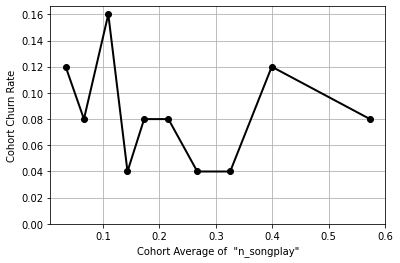

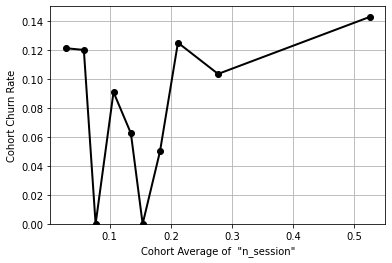

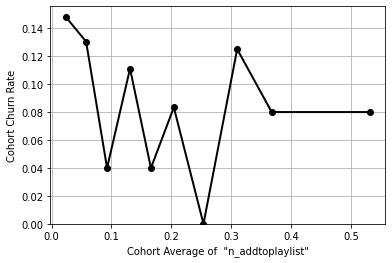

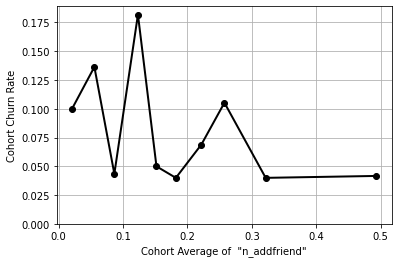

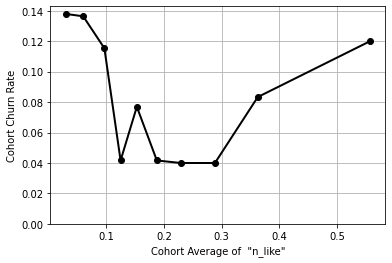

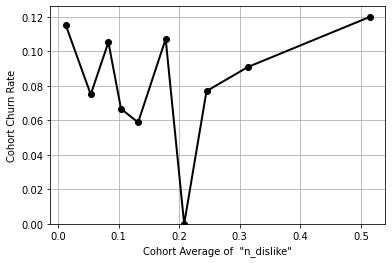

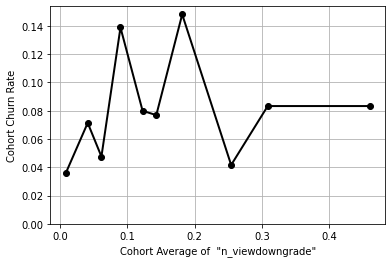

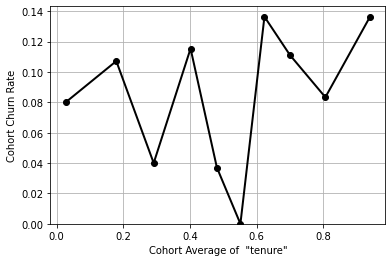

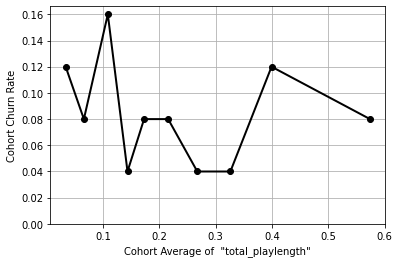

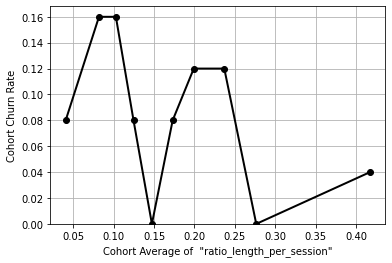

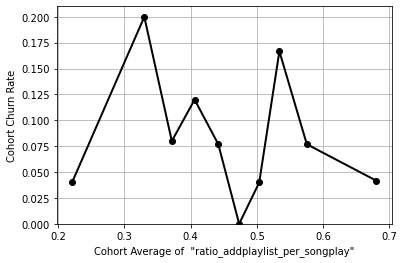

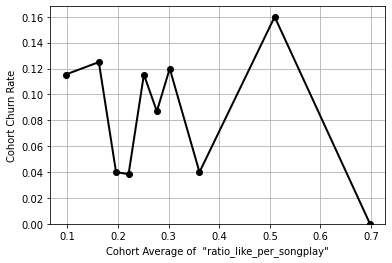

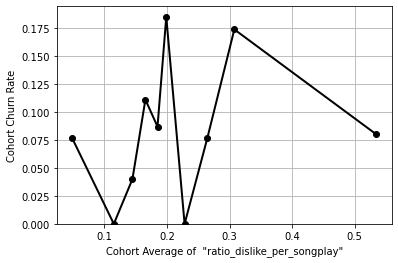

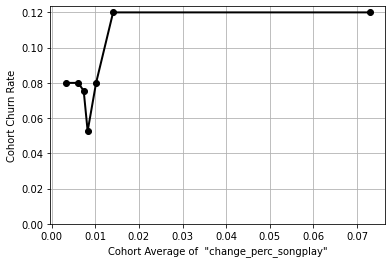

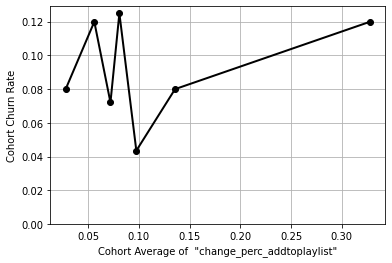

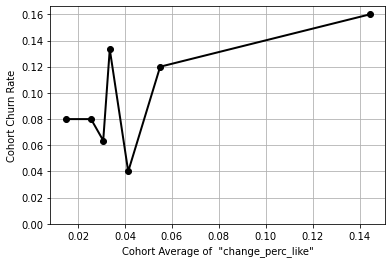

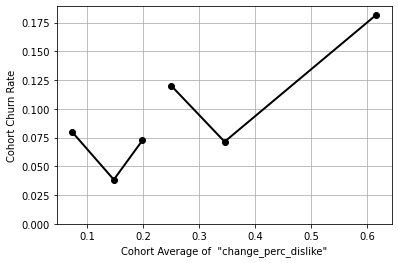

In [384]:
# Plot every metrics with NORMALIZED metrics. cohort analysis. 

metric_names = df_normalized.columns[:-1]

plot_metrics(metrics=metric_names, n_cohort=6, df_data=df_normalized)


#### Picking metrics based on the cohort analysis plots

As above all metrics plots shown, not every plot reveals corelation, select those possiblely showing pattern/trends/corelation from the cohort analysis plot, and zoom in or zoom out to look further.

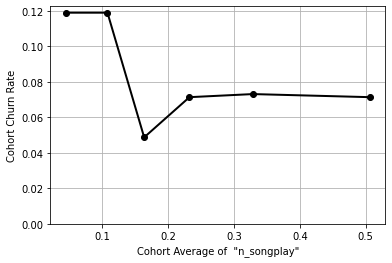

In [385]:
# n_songplay

cohort_plot('n_songplay', n_cohort=6, df_data=df_normalized)

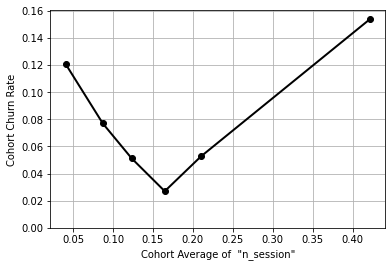

In [386]:
# n_session

cohort_plot('n_session', n_cohort=6, df_data=df_normalized)

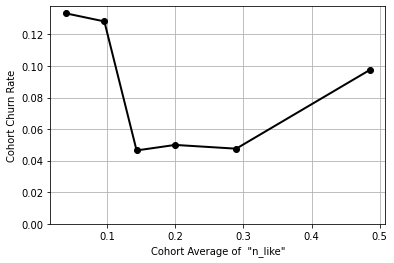

In [387]:
# n_like

cohort_plot('n_like', n_cohort=6, df_data=df_normalized)

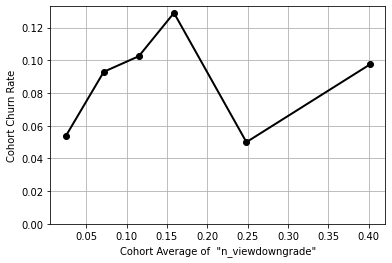

In [388]:
# n_viewdowngrade

cohort_plot('n_viewdowngrade', n_cohort=6, df_data=df_normalized)

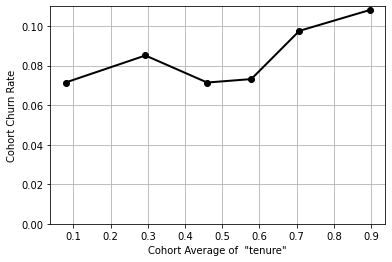

In [389]:
# tenure

cohort_plot('tenure', n_cohort=6, df_data=df_normalized)

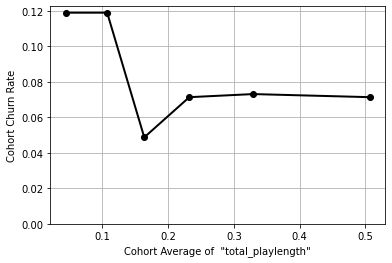

In [390]:
# total_playlength

cohort_plot('total_playlength', n_cohort=6, df_data=df_normalized)

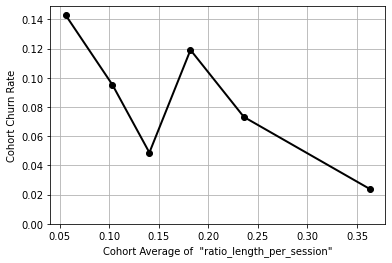

In [391]:
# ratio_length_per_session

cohort_plot('ratio_length_per_session', n_cohort=6, df_data=df_normalized)

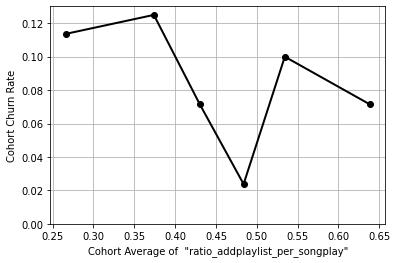

In [392]:
# ratio_addplaylist_per_songplay

cohort_plot('ratio_addplaylist_per_songplay', n_cohort=6, df_data=df_normalized)

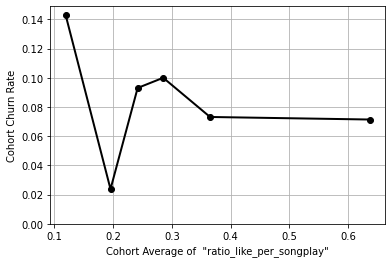

In [393]:
# ratio_like_per_songplay

cohort_plot('ratio_like_per_songplay', n_cohort=6, df_data=df_normalized)

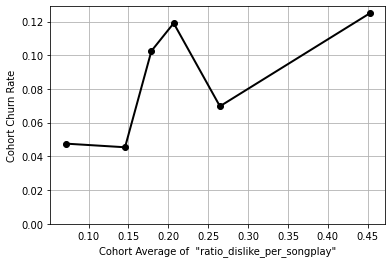

In [394]:
# ratio_dislike_per_songplay

cohort_plot('ratio_dislike_per_songplay', n_cohort=6, df_data=df_normalized)

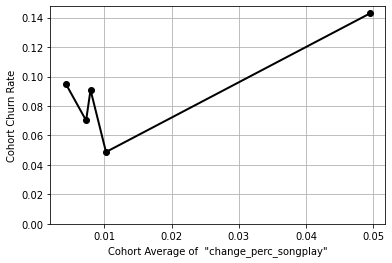

In [395]:
# change_perc_songplay 
# right skew. most group distributes before mean group. (we can see that 4 groups against 1 very long tailed group)
# (Strange, seems counter-intuitive)
# (the very last qcut cohort is very right long tail. highly possible of outlier. let's run a outlier check in 
# following cells)

cohort_plot('change_perc_songplay', n_cohort=6, df_data=df_normalized)

# but for
# those preceding group are negative %, and lower % number of songplay. (check detail value in qcut)
# which probably indicates: negative and lower the % change of songplay, the higher the churn rate
# can try remove outlier, probably should a down trend of churn

In [396]:
# outlier check. the vert last qcut group. significantly over the standard range. 

# help(pd.qcut(df_analytic['change_perc_songplay'], 6, duplicates='drop').cat)
pd.qcut(df_analytic['change_perc_songplay'], 6, duplicates='drop').cat.categories

IntervalIndex([(-0.831, -0.103], (-0.103, 0.0], (0.0, 0.104], (0.104, 0.578], (0.578, 112.0]], dtype='interval[float64, right]')

In [397]:
# the 'outer' group.
# check the churn user in the group. do they really showing any patterns that churn?

test_ids = df_analytic[(df_analytic.change_perc_songplay > 0.578) & (df_analytic.is_churn==1)].userId.values

# nothing much special. probably they just want to churn for no typical reason. 'outlier'-like
df_analytic[df_analytic.userId.isin(test_ids)]

,userId,observation_time,n_songplay,n_session,n_addtoplaylist,n_addfriend,n_like,n_dislike,n_viewdowngrade,tenure,total_playlength,ratio_length_per_session,ratio_addplaylist_per_songplay,ratio_like_per_songplay,ratio_dislike_per_songplay,change_perc_songplay,change_perc_addtoplaylist,change_perc_like,change_perc_dislike,is_churn
58,53,2018-11-05 12:34:56,584,11,16,6,21,6,4,12,143459,13041.7273,0.0274,0.0360,0.0103,0.0000,0.0000,0.0000,0.0000,0
59,53,2018-11-19 12:34:56,1405,12,34,20,59,14,13,26,349065,29088.7500,0.0242,0.0420,0.0100,1.4058,1.1250,1.8095,1.3333,1
69,61,2018-11-14 17:52:52,160,6,4,7,10,1,0,12,39070,6511.6667,0.0250,0.0625,0.0062,-0.8030,-0.8000,-0.7959,-0.8333,0
70,61,2018-11-28 17:52:52,657,7,24,5,25,5,5,26,163959,23422.7143,0.0365,0.0381,0.0076,3.1062,5.0000,1.5000,4.0000,1
181,100007,2018-11-01 11:45:09,110,4,2,2,4,1,2,30,28269,7067.2500,0.0182,0.0364,0.0091,0.0000,0.0000,0.0000,0.0000,0
182,100007,2018-11-15 11:45:09,96,5,1,2,4,0,2,44,24245,4849.0000,0.0104,0.0417,0.0000,-0.1273,-0.5000,0.0000,-1.0000,0
183,100007,2018-11-29 11:45:09,201,4,4,11,11,2,2,58,49934,12483.5000,0.0199,0.0547,0.0100,1.0938,3.0000,1.7500,1.0000,1
184,100008,2018-11-06 21:21:41,226,3,14,5,8,4,4,28,55483,18494.3333,0.0619,0.0354,0.0177,0.0000,0.0000,0.0000,0.0000,0
185,100008,2018-11-20 21:21:41,474,1,16,10,27,2,6,42,118382,118382.0000,0.0338,0.0570,0.0042,1.0973,0.1429,2.3750,-0.5000,1
203,200017,2018-11-01 20:16:43,186,9,4,4,14,8,1,2,46817,5201.8889,0.0215,0.0753,0.0430,0.0000,0.0000,0.0000,0.0000,0


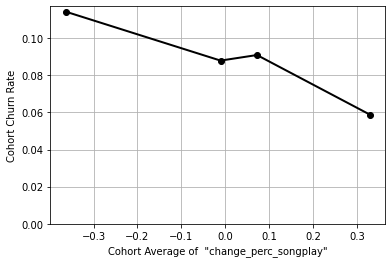

In [398]:
# After remove the 'outlier' qcut group, we do see a pattern with change % of song play.
# IN GENERAL:
# while users increase the number of song play in relative to previous time interval, are less likely to churn

data_test = \
df_analytic[~df_analytic.userId.isin((df_analytic[df_analytic.change_perc_songplay > 0.578].userId.values))]

cohort_plot('change_perc_songplay', 
            n_cohort=5, 
            df_data=data_test
)

# Now showing a corelation (negative like): increase of songplay %, possibly reduce chrun rate
# So we will keep this metric (feature).

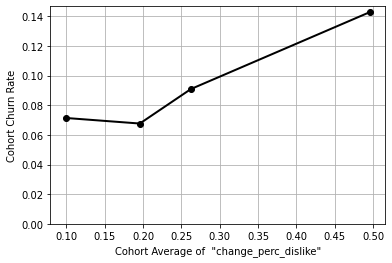

In [399]:
# change_perc_dislike

cohort_plot('change_perc_dislike', n_cohort=6, df_data=df_normalized)

In [440]:
# Select metrics

metrics_selected = ['n_songplay', 
                    'n_session', 
                    'n_like', 
                    'n_viewdowngrade', 
                    'tenure', 
                    'total_playlength', 
                    'ratio_length_per_session', 
                    'ratio_addplaylist_per_songplay', 
                    'ratio_like_per_songplay', 
                    'ratio_dislike_per_songplay', 
                    'change_perc_songplay', 
                    'change_perc_dislike']

---
## Machine Learning

Churn forcasting / estimating probabilities.

Two approach:
1. Logistic Regression
2. XGBoost (Decision Trees)

### Logistic Regression

https://web.stanford.edu/class/archive/cs/cs109/cs109.1178/lectureHandouts/220-logistic-regression.pdf

"Logistic regression is a classification algorithm1 that works by trying to learn a function that
approximates P(Y |X). It makes the central assumption that P(Y |X) can be approximated as a
sigmoid function applied to a linear combination of input features. It is particularly important to
learn because logistic regression is the basic building block of artificial neural networks."

In [416]:
# https://github.com/PacktPublishing/Machine-Learning-with-scikit-learn-Quick-Start-Guide/blob/master/Chapter_03.ipynb

In [496]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score


In [586]:
# features

# independent variables values. the X
features = df_normalized[metrics_selected].values

# dependent variable. the y
target = df_normalized['is_churn'].values

features


array([[0.03977591, 0.05769231, 0.01351351, ..., 0.        , 0.00735268,
        0.2       ],
       [0.10756303, 0.09615385, 0.04954955, ..., 0.15866388, 0.02127988,
        0.6       ],
       [0.23361345, 0.17307692, 0.14864865, ..., 0.32150313, 0.00735268,
        0.2       ],
       ...,
       [0.22829132, 0.15384615, 0.41891892, ..., 0.15240084, 0.00735268,
        0.2       ],
       [0.10588235, 0.11538462, 0.20720721, ..., 0.21503132, 0.00266951,
        0.13334   ],
       [0.12717087, 0.09615385, 0.19369369, ..., 0.3131524 , 0.00908006,
        0.35      ]])

In [605]:
# Create train set, test set

X_train, X_test, y_train, y_test = \
train_test_split(features, target, test_size = 0.3, random_state = 42, stratify=target)



# Initialize and logistic_regression instance
log_reg = linear_model.LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)


# Fitting the model
log_reg.fit(X_train, y_train)


LogisticRegression(penalty='l1', solver='liblinear')

In [606]:
log_reg.score(X_test, y_test)

0.92

In [607]:
y_true = y_test.copy()
y_pred = log_reg.predict(X_test)
f1_score(y_true, y_pred, average='macro')

0.4791666666666667

In [589]:
# Check each label's probability estimated for test set data point
prob_estimated = log_reg.predict_proba(X_test)

prob_for_churn = [round(x[1],3) for x in prob_estimated]

prob_for_churn

[0.085,
 0.079,
 0.111,
 0.091,
 0.09,
 0.08,
 0.074,
 0.086,
 0.079,
 0.075,
 0.098,
 0.086,
 0.069,
 0.087,
 0.092,
 0.061,
 0.048,
 0.087,
 0.115,
 0.069,
 0.084,
 0.077,
 0.094,
 0.094,
 0.074,
 0.077,
 0.093,
 0.099,
 0.067,
 0.089,
 0.086,
 0.095,
 0.042,
 0.086,
 0.06,
 0.066,
 0.091,
 0.082,
 0.079,
 0.076,
 0.054,
 0.107,
 0.084,
 0.077,
 0.072,
 0.095,
 0.105,
 0.098,
 0.11,
 0.094,
 0.075,
 0.076,
 0.057,
 0.085,
 0.07,
 0.071,
 0.117,
 0.075,
 0.067,
 0.076,
 0.103,
 0.096,
 0.068,
 0.075,
 0.089,
 0.071,
 0.078,
 0.058,
 0.076,
 0.077,
 0.088,
 0.076,
 0.106,
 0.102,
 0.091]

In [590]:
log_reg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [591]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [596]:
X_train[0]

array([0.16330532, 0.09615385, 0.12612613, 0.08163265, 0.41666667,
       0.16189764, 0.18567711, 0.59773829, 0.22320551, 0.21085595,
       0.0155562 , 0.3       ])

In [604]:
# test extreme


test_data = np.array([0.16330532, 0.09615385, 0.12612613, 0.08163265, 0.41666667,
       0.16189764, 0.18567711, 0.59773829, 0.22320551, 0.21085595,
       0.0155562 , 0.3       ])

test_data

print(log_reg.predict([test_data]))

print(log_reg.predict_proba([test_data]))

[1]
[[4.21884749e-15 1.00000000e+00]]


In [611]:
# tuning params


#Building the model with L1 penality 

logistic_regression = linear_model.LogisticRegression(solver='liblinear', penalty='l1')

#Using GridSearchCV to search for the best parameter

grid = GridSearchCV(logistic_regression, {'C':[0.0001, 0.001, 0.01, 0.1, 10]})
grid.fit(X_train, y_train)

# Print out the best parameter

print("The most optimal inverse regularization strength is:", grid.best_params_)

The most optimal inverse regularization strength is: {'C': 0.0001}


In [612]:
#Initializing an logistic regression object

logistic_regression = linear_model.LogisticRegression(C = 0.0001, penalty = 'l1', solver='liblinear')

#Fitting the model to the training and test sets

logistic_regression.fit(X_train, y_train)

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [613]:
#Accuracy score of the logistic regression model

logistic_regression.score(X_test, y_test)

0.92

In [614]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [615]:
logistic_regression.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

---

In [633]:
# https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

[01:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[01:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[01:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[01:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

[01:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:29:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

In [617]:
import xgboost

In [618]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [619]:
xgb_reg.predict(X_test)

array([ 2.5441546e-03,  7.6110703e-03,  2.7221987e-01,  8.3830014e-02,
        9.3002886e-02,  1.2091474e-01,  3.3400643e-03,  3.0967560e-01,
        9.1236522e-03,  3.4645468e-02,  1.7715242e-02,  5.9695523e-02,
        4.9246796e-03,  1.6802931e-02, -2.4855782e-03, -2.8276158e-02,
        3.2433966e-01, -1.7131846e-02,  7.2600335e-02,  2.3726557e-01,
       -8.5335951e-03, -1.4812835e-02,  2.1766596e-01,  2.6834115e-01,
       -3.2099877e-03, -1.1443262e-02,  9.7414993e-02, -9.8729297e-04,
       -7.5067504e-04,  1.5972089e-02,  9.7679503e-02,  4.4271361e-02,
        1.6457245e-01,  2.3676367e-01, -2.3872693e-04,  8.2516506e-02,
        2.2595757e-01,  6.5373994e-02, -2.6107807e-02,  3.3870578e-01,
       -1.8779038e-02, -6.8133056e-02,  1.7976534e-02,  6.2916748e-02,
       -1.4056264e-02,  2.2806424e-01,  1.8539185e-02,  3.5924140e-01,
        1.9582677e-01,  4.1428115e-02, -6.9827870e-03, -1.1477195e-02,
        8.5238464e-02, -8.2580205e-03,  3.4027847e-03, -5.0682807e-03,
      

In [622]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [624]:
xgb_clf = xgboost.XGBRFClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

[01:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=12,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact',
                use_label_encoder=False, validate_parameters=1, verbosity=None)

In [621]:
xgb_clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [625]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [627]:
# gridseach

param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}


# Init classifier
xgb_cl = xgboost.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
grid_cv.fit(X_train, y_train)

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/apple/pyprojects/

[01:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/apple/pyprojects/project_churn_spark/venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, v

In [630]:
grid_cv.best_score_

0.5343931982296762

In [629]:
grid_cv.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])